# EDA: Exploring trends in Popular Videos on YouTube using YouTube API

In [2]:
import pandas as pd
from IPython.display import JSON

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Google API
from googleapiclient.discovery import build

In [74]:
api_key = 'IzaSyDrutKeQG62zE0ACZB-yCixmCW5gAh1cZQ' 
youtube = build('youtube', 'v3', developerKey=api_key)

### Data Retrieval

In [4]:
def get_popular_videos(youtube, n_videos, region_code):
    '''
    Sends a request to YouTube API to get the current most popular videos in a given country.
    Arguments:
        youtube: googleapiclient.discovery's object
        n_videos: number of videos to be retrieved
        region_code: country code for which you're retrieving videos
    Returns:
        JSON response 
    '''
    request = youtube.videos().list(
                part='snippet,contentDetails,statistics',
                chart='mostPopular',
                maxResults=n_videos,
                regionCode=region_code)
    response = request.execute()
    return response

In [5]:
def get_video_categories(youtube, region_code):
    '''
    Sends a request to YouTube API to get the video categories in a given country.
    Arguments:
        youtube: googleapiclient.discovery's object
        region_code: country code for which you're retrieving videos
    Returns:
        JSON response 
    '''
    request = youtube.videoCategories().list(
                part='snippet',
                regionCode=region_code)
    response = request.execute()
    return response

In [6]:
popular_videos_response = get_popular_videos(youtube, n_videos=50, region_code='US')

In [7]:
JSON(popular_videos_response)

<IPython.core.display.JSON object>

In [8]:
video_categories_response = get_video_categories(youtube, region_code='US')

In [9]:
JSON(video_categories_response)

<IPython.core.display.JSON object>

### Functions to create Dataframes from JSON Responses

In [10]:
def create_popular_videos_df(response):
    '''
    Creates dataframe from Popular Videos JSON Response.
    Arguments:
        response: JSON response
    Returns:
        Dataframe containing the following information for each video: channelTitle, channelId, title, description, tags,
        categoryId, publishedAt, viewCount, likeCount, commentCount
    '''
    all_videos_info = []
    
    for video in response['items']:
        
        attributes = {'snippet' : ['channelTitle', 'channelId', 'title', 'description', 'tags', 'categoryId', 'publishedAt'],
                      'statistics' : ['viewCount', 'likeCount', 'commentCount']}
        
        video_info = {}
        for k in attributes.keys():
            for a in attributes[k]:
                try:
                    video_info[a] = video[k][a]
                except:
                    video_info[a] = None
        
        all_videos_info.append(video_info)   
        
    return pd.DataFrame(all_videos_info)

In [11]:
def create_video_categories_dict(response):
    '''
    Creates dataframe from Video Categories JSON Response.
    Arguments:
        response: JSON response
    Returns:
        Dataframe containing the title and id for each video category
    '''
    titles = []
    ids = []
        
    for i in range(len(response['items'])):
        ids.append(response['items'][i]['id'])
        titles.append(response['items'][i]['snippet']['title'])
    
    all_categories_info = dict(zip(ids, titles))
        
    return all_categories_info

In [12]:
popular_videos = create_popular_videos_df(popular_videos_response)

In [13]:
popular_videos.head()

,channelTitle,channelId,title,description,tags,categoryId,publishedAt,viewCount,likeCount,commentCount
0,TaylorSwiftVEVO,UCANLZYMidaCbLQFWXBC95Jg,Taylor Swift - Bejeweled (Official Music Video),Official music video for “Bejeweled” by Taylor...,"[taylor swift, taylor, swift, bejeweled, midni...",10,2022-10-25T04:00:09Z,9123178,923378,34704
1,Marvel Entertainment,UCvC4D8onUfXzvjTOM-dBfEA,Marvel Studios’ Ant-Man and The Wasp: Quantuma...,"This February, enter the Quantum Realm. Watch ...","[marvel, comics, official, mcu, ant-man, the w...",24,2022-10-24T16:00:40Z,16263548,799353,32207
2,Marvel Entertainment,UCvC4D8onUfXzvjTOM-dBfEA,Marvel Studios’ Special Presentation: The Guar...,This holiday season is going to be out of this...,"[marvel, comics]",24,2022-10-25T18:30:18Z,2865802,183873,6236
3,The Tonight Show Starring Jimmy Fallon,UC8-Th83bH_thdKZDJCrn88g,Taylor Swift Spills on Record-Breaking Midnigh...,Taylor Swift talks about collaborating with Zo...,"[tonight show, jimmy fallon, NBC, NBC TV, Tele...",23,2022-10-25T03:48:56Z,1656560,108119,3035
4,The Official Pokémon YouTube channel,UCFctpiB_Hnlk3ejWfHqSm6Q,"Meet Greavard, the Ghost Dog Pokémon! 🐶🕯️ | Po...",Greavard is so affectionate that paying it any...,"[Pokemon Scarlet, Pokemon Violet, Generation 9...",20,2022-10-25T13:30:16Z,858651,47148,4141


In [14]:
video_categories = create_video_categories_dict(video_categories_response)

In [15]:
video_categories

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

### Mapping the categories

In [16]:
# Adding new category title column to the dataset
popular_videos['categoryTitle'] = popular_videos['categoryId'].map(video_categories)

In [17]:
popular_videos.head()

,channelTitle,channelId,title,description,tags,categoryId,publishedAt,viewCount,likeCount,commentCount,categoryTitle
0,TaylorSwiftVEVO,UCANLZYMidaCbLQFWXBC95Jg,Taylor Swift - Bejeweled (Official Music Video),Official music video for “Bejeweled” by Taylor...,"[taylor swift, taylor, swift, bejeweled, midni...",10,2022-10-25T04:00:09Z,9123178,923378,34704,Music
1,Marvel Entertainment,UCvC4D8onUfXzvjTOM-dBfEA,Marvel Studios’ Ant-Man and The Wasp: Quantuma...,"This February, enter the Quantum Realm. Watch ...","[marvel, comics, official, mcu, ant-man, the w...",24,2022-10-24T16:00:40Z,16263548,799353,32207,Entertainment
2,Marvel Entertainment,UCvC4D8onUfXzvjTOM-dBfEA,Marvel Studios’ Special Presentation: The Guar...,This holiday season is going to be out of this...,"[marvel, comics]",24,2022-10-25T18:30:18Z,2865802,183873,6236,Entertainment
3,The Tonight Show Starring Jimmy Fallon,UC8-Th83bH_thdKZDJCrn88g,Taylor Swift Spills on Record-Breaking Midnigh...,Taylor Swift talks about collaborating with Zo...,"[tonight show, jimmy fallon, NBC, NBC TV, Tele...",23,2022-10-25T03:48:56Z,1656560,108119,3035,Comedy
4,The Official Pokémon YouTube channel,UCFctpiB_Hnlk3ejWfHqSm6Q,"Meet Greavard, the Ghost Dog Pokémon! 🐶🕯️ | Po...",Greavard is so affectionate that paying it any...,"[Pokemon Scarlet, Pokemon Violet, Generation 9...",20,2022-10-25T13:30:16Z,858651,47148,4141,Gaming


### Extracting channel ids

In [18]:
channel_ids = popular_videos['channelId'].values.tolist()

In [19]:
channel_ids

['UCANLZYMidaCbLQFWXBC95Jg',
 'UCvC4D8onUfXzvjTOM-dBfEA',
 'UCvC4D8onUfXzvjTOM-dBfEA',
 'UC8-Th83bH_thdKZDJCrn88g',
 'UCFctpiB_Hnlk3ejWfHqSm6Q',
 'UCY1kMZp36IQSyNx_9h4mpCg',
 'UCtNdVINwfYFTQEEZgMiQ8FA',
 'UC8-Th83bH_thdKZDJCrn88g',
 'UCJcc1x6emfrQquiV8Oe_pug',
 'UCX6OQ3DkcsbYNE6H8uQQuVA',
 'UC0ZV6M2THA81QT9hrVWJG3A',
 'UCM9r1xn6s30OnlJWb-jc3Sw',
 'UCdARoxad2UaIQPDy6fbz4Nw',
 'UCJ0uqCI0Vqr2Rrt1HseGirg',
 'UCMUu7nPaq5CIh6ul361bDzw',
 'UCHfF8wFnipMeDpJf8OmMxDg',
 'UCY6Ij8zOds0WJEeqCLOnqOQ',
 'UCQSEAbOs6vsJfy7WN7iYaGQ',
 'UCnlXUVuzrO_BllppmUCosig',
 'UClMs26ViHFMy7MS897Alcxw',
 'UCQIUhhcmXsu6cN6n3y9-Pww',
 'UCzJXNzqz6VMHSNInQt_7q6w',
 'UCDVYQ4Zhbm3S2dlz7P1GBDg',
 'UC-vaBe-YMpvcZL5rQ5OopZw',
 'UCBBsPuUY-8UwkSim4zLXp1w',
 'UCcOkA2Xmk1valTOWSyKyp4g',
 'UCpZy-Hfqcxf-R7nQzlv9Bvw',
 'UCgMJGv4cQl8-q71AyFeFmtg',
 'UCWJ2lWNubArHWmf3FIHbfcQ',
 'UCrOR14O-kBHEyrLQRdHJgDQ',
 'UC49ta0RHXJUiID5KWRkcySw',
 'UCFctpiB_Hnlk3ejWfHqSm6Q',
 'UCy06jHRS_82N2i5v1YL7glQ',
 'UCNmfuDtKkWJfWe4zh9MBrUA',
 'UC4uG6XoaVfb

In [20]:
# Removing channelId and categoryId columns from the dataset
popular_videos.drop(['channelId', 'categoryId'], axis=1, inplace=True)

In [21]:
popular_videos.head() 

,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,categoryTitle
0,TaylorSwiftVEVO,Taylor Swift - Bejeweled (Official Music Video),Official music video for “Bejeweled” by Taylor...,"[taylor swift, taylor, swift, bejeweled, midni...",2022-10-25T04:00:09Z,9123178,923378,34704,Music
1,Marvel Entertainment,Marvel Studios’ Ant-Man and The Wasp: Quantuma...,"This February, enter the Quantum Realm. Watch ...","[marvel, comics, official, mcu, ant-man, the w...",2022-10-24T16:00:40Z,16263548,799353,32207,Entertainment
2,Marvel Entertainment,Marvel Studios’ Special Presentation: The Guar...,This holiday season is going to be out of this...,"[marvel, comics]",2022-10-25T18:30:18Z,2865802,183873,6236,Entertainment
3,The Tonight Show Starring Jimmy Fallon,Taylor Swift Spills on Record-Breaking Midnigh...,Taylor Swift talks about collaborating with Zo...,"[tonight show, jimmy fallon, NBC, NBC TV, Tele...",2022-10-25T03:48:56Z,1656560,108119,3035,Comedy
4,The Official Pokémon YouTube channel,"Meet Greavard, the Ghost Dog Pokémon! 🐶🕯️ | Po...",Greavard is so affectionate that paying it any...,"[Pokemon Scarlet, Pokemon Violet, Generation 9...",2022-10-25T13:30:16Z,858651,47148,4141,Gaming


In [22]:
# Checking data types
popular_videos.dtypes 

channelTitle     object
title            object
description      object
tags             object
publishedAt      object
viewCount        object
likeCount        object
commentCount     object
categoryTitle    object
dtype: object

In [24]:
# Convert count columns to numeric values
numeric_cols = ['viewCount', 'likeCount', 'commentCount']
popular_videos[numeric_cols] = popular_videos[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [25]:
popular_videos.dtypes

channelTitle     object
title            object
description      object
tags             object
publishedAt      object
viewCount         int64
likeCount         int64
commentCount      int64
categoryTitle    object
dtype: object

### Enriching data

### Getting channel statistics

In [62]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [63]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [64]:
channel_stats

,channelName,subscribers,views,totalVideos
0,MrBeast,107000000,17814252847,731
1,Marvel Entertainment,19800000,5269340734,8134
2,Apex Legends,2770000,515128199,148
3,TaylorSwiftVEVO,25800000,23724681577,261
4,Fox League,78300,67192226,1164
5,REAL ONES with Jon Bernthal,399000,14576555,53
6,KairosTime Gaming,904000,256718647,1028
7,Bailey Sarian,6610000,851791411,471
8,Sophia Grace,3410000,829760263,145
9,XXXTENTACION,38000000,9928195936,127


In [65]:
channel_stats.dtypes

channelName    object
subscribers    object
views          object
totalVideos    object
dtype: object

In [70]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_stats[numeric_cols] = channel_stats[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [71]:
channel_stats.dtypes

channelName    object
subscribers     int64
views           int64
totalVideos     int64
dtype: object

### Data Visualization

<AxesSubplot:xlabel='views', ylabel='subscribers'>

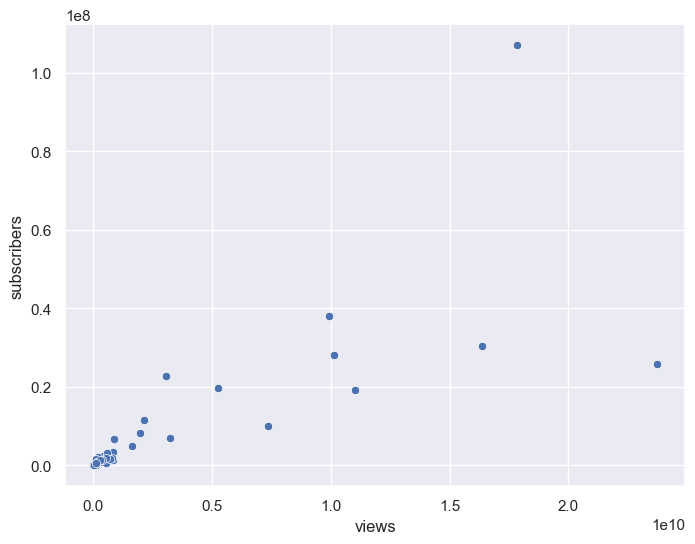

In [72]:
# Subscribers vs views
sns.scatterplot(data = channel_stats, x = "views", y = "subscribers")

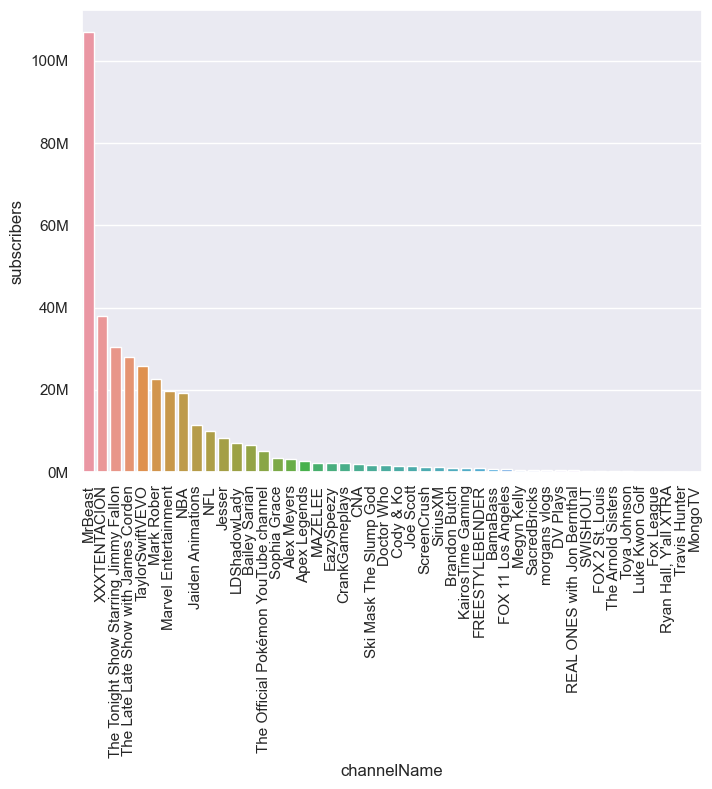

In [41]:
# Bar chart of subscribers count of channels that produced the popular videos
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_stats.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [36]:
subscribers = channel_stats['subscribers']
subscribers_groups = []
subscribers_groups.append(subscribers.where(subscribers > 30000000).count())
subscribers_groups.append(subscribers.where((subscribers < 30000000) & (subscribers >= 15000000)).count())
subscribers_groups.append(subscribers.where((subscribers < 15000000) & (subscribers >= 5000000)).count())
subscribers_groups.append(subscribers.where((subscribers < 5000000) & (subscribers >= 1000000)).count())
subscribers_groups.append(subscribers.where((subscribers < 1000000) & (subscribers >= 500000)).count())
subscribers_groups.append(subscribers.where(subscribers < 500000).count())

In [38]:
subscribers_labels = ['> 30M', '15M - 30M', '5M - 15M', '1M - 5M', '500K - 1M', '< 500k']

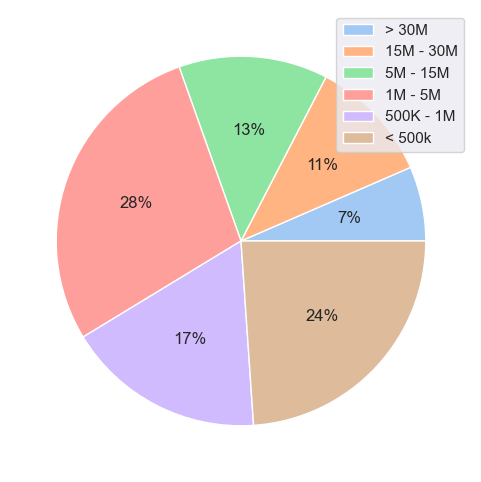

In [43]:
# Pie chart of percentage of channels that falls into each category of subscribers count
plt.figure(figsize=(6, 6))
colors = sns.color_palette('pastel')
plt.pie(subscribers_groups, autopct='%.0f%%', colors=colors)
plt.legend(subscribers_labels, loc='best')
plt.show()

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

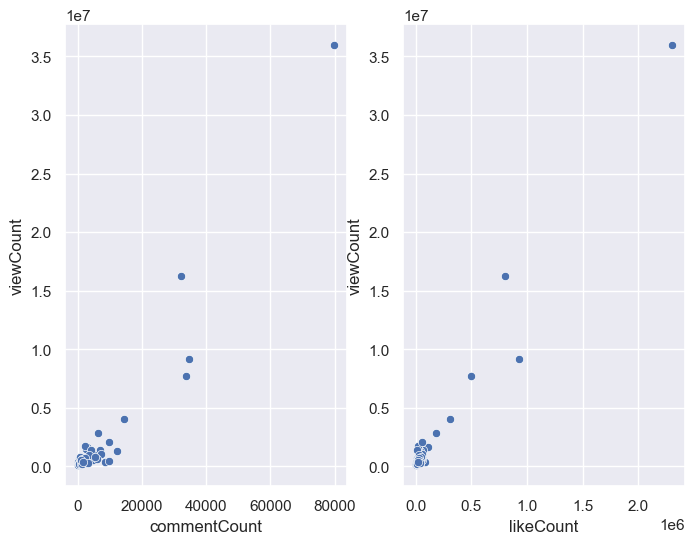

In [73]:
# Views vs comments + views vs like count
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = popular_videos, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = popular_videos, x = "likeCount", y = "viewCount", ax=ax[1])